<a href="https://colab.research.google.com/github/BBulMushroom/CIFAR_10_classification/blob/ResNet9/CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cifar10 image classification**
******************************************
**점수관련**  
본 프로젝트는 Accuracy 점수와 보고서를 성적에 반영할 예정입니다. 평가 항목은 아래와 같습니다. 

A. 결과 (40%)
- Metric 성능 :(이미지 분류 - Accuracy)

B. 신규성 (30%)
- Network 변경 내용 - **필수**
- 성능 개선 및 overfitting 방지 시도 (ex. train validation split)

C. 이론적 근거 (20%)
- 기존 baseline과의 차별점 
- 성능 개선을 위한 시도와 이유

D. 보고서 완성도 (10%)

******************************************
**보고서**
1. 연구 목적
2. 모델 구조
3. 실험 내용
4. 실험 결과
5. 고찰 및 결론
6. Colab 파일 (동작 가능여부)

제출하실 파일은 **주피터 노트북 파일**('.ipynb',파일>다운로드)과 **결과 보고서**(pdf)입니다.
******************************************
**코드 검증**  
- 코드 성능 평가(metric)는 torchvision.datasets에 있는 cifar10의 testset을 사용해 Accuracy로 평가합니다.
- pretrain 모델 사용 불가능합니다.

또한 Random 라이브러리 사용시에 seed 고정하는 등 재현을 고려하시고 코딩부탁드립니다. 
******************************************
**GPU 사용 법**  
런타임 > 런타임 유형 변경 > 하드웨어 가속기에서 GPU를 선택하면 GPU를 사용 할 수 있습니다.  
******************************************
**Colab 사용시 유의사항**  
12시간 단위로 가상머신을 사용할 수 있고 12시간이 지나면 모든 파일과 작업로그들이 초기화 됩니다. 또한, 12시간 넘게 GPU를 사용하기는 어려우니 일찍 시작하셔서 틈틈히 실험해보시는 것을 추천드립니다.


******************************************
**Q?**

In [14]:
# Training

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from google.colab import drive
import time

drive.mount('/content/gdrive')

# 하이퍼 파라미터
EPOCH = 20
batch_size = 400
learning_rate = 1e-3
grad_clip = 0.1
weight_decay = 1e-4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

# 분류 Class list
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# 이미지 전처리
torch.manual_seed(500)  # 시드 고정
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True)]
    )
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    )

# Dataset. 변경 불가
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cuda:0 is available
Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Baseline CNN Network

def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
        
    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    
    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    
    self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out


# Network 선언
net = ResNet9(3, 10).to(device)

In [16]:
# criterion. 변경 '가능'
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)

# Scheduler
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr = learning_rate, epochs=EPOCH, steps_per_epoch=len(trainloader))

loss_ = []
n = len(trainloader)

# Training
for epoch in range(EPOCH): 

  running_loss = 0.0
  start = time.time()
  for i, data in tqdm(enumerate(trainloader, 0)):
    
    inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터

    outputs = net(inputs)
    loss = criterion(outputs, labels) # 크로스 엔트로피 손실함수 계산 

    loss.backward() # backpropagation
    nn.utils.clip_grad_value_(net.parameters(), grad_clip)  # Gradiant clipping

    optimizer.step() # 가중치 최적화
    optimizer.zero_grad() # 배치마다 optimizer 초기화

    running_loss += loss.item()
    scheduler.step()
  
  torch.save(net.state_dict() ,'/content/gdrive/Shareddrives/전자공학종합설계/ResNet//model_ckpt.pt') # 모델 저장, path 수정
  loss_.append(running_loss / n)
  print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))
  print("epoch time :", time.time()-start)

  correct = 0
  total = 0
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predicted):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))


125it [01:20,  1.55it/s]


[1] loss: 1.477
epoch time : 80.94216179847717
Accuracy of the network on the 10000 test images: 60 %


125it [01:20,  1.55it/s]


[2] loss: 1.049
epoch time : 80.91485047340393
Accuracy of the network on the 10000 test images: 69 %


125it [01:21,  1.54it/s]


[3] loss: 0.831
epoch time : 81.32015752792358
Accuracy of the network on the 10000 test images: 75 %


125it [01:21,  1.54it/s]


[4] loss: 0.680
epoch time : 81.47382140159607
Accuracy of the network on the 10000 test images: 79 %


125it [01:21,  1.54it/s]


[5] loss: 0.582
epoch time : 81.19705867767334
Accuracy of the network on the 10000 test images: 82 %


125it [01:20,  1.54it/s]


[6] loss: 0.496
epoch time : 81.12589168548584
Accuracy of the network on the 10000 test images: 84 %


125it [01:20,  1.55it/s]


[7] loss: 0.430
epoch time : 80.75819373130798
Accuracy of the network on the 10000 test images: 85 %


125it [01:20,  1.55it/s]


[8] loss: 0.378
epoch time : 80.79837203025818
Accuracy of the network on the 10000 test images: 85 %


125it [01:20,  1.54it/s]


[9] loss: 0.329
epoch time : 81.06469964981079
Accuracy of the network on the 10000 test images: 87 %


125it [01:21,  1.54it/s]


[10] loss: 0.287
epoch time : 81.38853573799133
Accuracy of the network on the 10000 test images: 88 %


125it [01:21,  1.54it/s]


[11] loss: 0.252
epoch time : 81.34787178039551
Accuracy of the network on the 10000 test images: 89 %


125it [01:21,  1.53it/s]


[12] loss: 0.210
epoch time : 81.59529614448547
Accuracy of the network on the 10000 test images: 89 %


125it [01:21,  1.53it/s]


[13] loss: 0.177
epoch time : 81.71106672286987
Accuracy of the network on the 10000 test images: 90 %


125it [01:21,  1.53it/s]


[14] loss: 0.148
epoch time : 81.7844820022583
Accuracy of the network on the 10000 test images: 90 %


125it [01:21,  1.54it/s]


[15] loss: 0.123
epoch time : 81.4880702495575
Accuracy of the network on the 10000 test images: 91 %


125it [01:21,  1.54it/s]


[16] loss: 0.105
epoch time : 81.52445125579834
Accuracy of the network on the 10000 test images: 91 %


125it [01:20,  1.55it/s]


[17] loss: 0.086
epoch time : 80.82116603851318
Accuracy of the network on the 10000 test images: 91 %


125it [01:21,  1.54it/s]


[18] loss: 0.075
epoch time : 81.23710703849792
Accuracy of the network on the 10000 test images: 91 %


125it [01:20,  1.55it/s]


[19] loss: 0.069
epoch time : 80.9856607913971
Accuracy of the network on the 10000 test images: 91 %


125it [01:20,  1.54it/s]


[20] loss: 0.065
epoch time : 81.04107069969177
Accuracy of the network on the 10000 test images: 91 %


# Evaluation

In [19]:
# Evaluation

# 수정
net = ResNet9(3, 10)
net.to(device)
net.load_state_dict(torch.load('/content/gdrive/Shareddrives/전자공학종합설계/ResNet//model_ckpt.pt')) # 저장된 모델 불러오기


# 이하 전체 수정 불가
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy of the network on the 10000 test images: 91 %
Accuracy for class plane is: 93.7 %
Accuracy for class car   is: 96.0 %
Accuracy for class bird  is: 88.0 %
Accuracy for class cat   is: 81.2 %
Accuracy for class deer  is: 93.5 %
Accuracy for class dog   is: 85.9 %
Accuracy for class frog  is: 94.1 %
Accuracy for class horse is: 94.3 %
Accuracy for class ship  is: 95.2 %
Accuracy for class truck is: 94.3 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


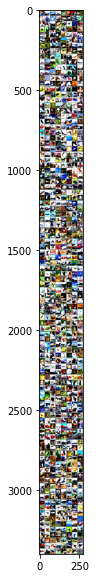

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:   ship   cat plane  bird  ship   dog  frog horse


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

net = ResNet9(3, 10)
net.to(device)
net.load_state_dict(torch.load('/content/gdrive/Shareddrives/전자공학종합설계/ResNet//model_ckpt.pt'))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))